In [1]:
import os
from sklearn.model_selection import train_test_split
import shutil
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers, Model
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint


In [3]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [4]:
import tensorflow as tf

# Kiểm tra số lượng GPU có sẵn
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

# Kiểm tra chi tiết các GPU
for gpu in gpus:
    print(f"Device Name: {gpu.name}")
    print(f"Device Type: {gpu.device_type}")

    # Lấy và in thông tin bộ nhớ GPU (sử dụng phương pháp khác nếu cần)
    try:
        # In thông tin chi tiết về thiết bị
        device_details = tf.config.experimental.get_device_details(gpu)
        print(f"Device Details: {device_details}")
    except Exception as e:
        print(f"Could not get detailed info for {gpu.name}: {e}")

# Kiểm tra khả năng tương thích CUDA và cuDNN
try:
    from tensorflow.python.framework import ops
    build_info = tf.sysconfig.get_build_info()
    print("CUDA Version:", build_info['cuda_version'])
    print("cuDNN Version:", build_info['cudnn_version'])
except Exception as e:
    print(f"Could not get CUDA and cuDNN versions: {e}")


Num GPUs Available:  1
Device Name: /physical_device:GPU:0
Device Type: GPU
Device Details: {'device_name': 'Quadro P2000', 'compute_capability': (6, 1)}
CUDA Version: 64_112
cuDNN Version: 64_8


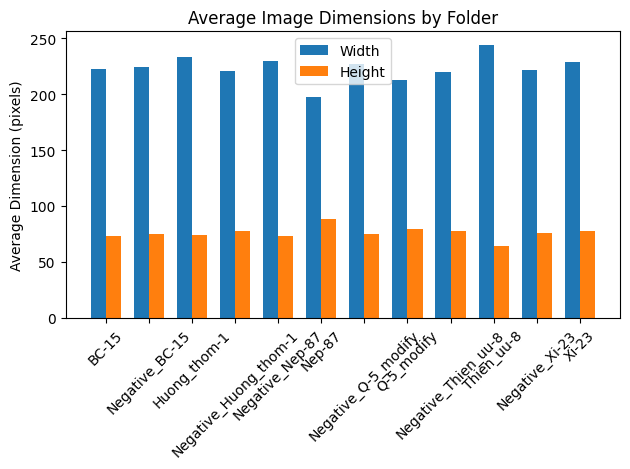

In [2]:
root_dir = "Rice_photos"
folder_dims = {}

for subdir, _, files in os.walk(root_dir):
    if files:
        dims = []
        for file in files:
            img_path = os.path.join(subdir, file)
            if img_path.endswith(('.png', '.jpg', '.jpeg')):
                img = Image.open(img_path)
                dims.append(img.size)  # img.size returns (width, height)

        # Calculate the average (x, y) dimensions for the current folder
        if dims:
            avg_dims = np.mean(dims, axis=0)
            folder_name = os.path.basename(subdir)
            folder_dims[folder_name] = avg_dims

folders = list(folder_dims.keys())
avg_widths = [dims[0] for dims in folder_dims.values()]
avg_heights = [dims[1] for dims in folder_dims.values()]

fig, ax = plt.subplots()
width = 0.35 

# Bar chart for width and height
ax.bar(np.arange(len(folders)) - width/2, avg_widths, width, label='Width')
ax.bar(np.arange(len(folders)) + width/2, avg_heights, width, label='Height')
ax.set_ylabel('Average Dimension (pixels)')
ax.set_title('Average Image Dimensions by Folder')
ax.set_xticks(np.arange(len(folders)))
ax.set_xticklabels(folders, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

In [4]:
print(folder_dims)

{'BC-15': array([222.76281352,  72.77589967]), 'Negative_BC-15': array([224.35214324,  75.33152469]), 'Huong_thom-1': array([233.59494275,  73.64742366]), 'Negative_Huong_thom-1': array([220.9211295,  77.2375852]), 'Negative_Nep-87': array([229.93080054,  73.1431479 ]), 'Nep-87': array([197.57469621,  88.3659757 ]), 'Negative_Q-5_modify': array([226.95866667,  74.87066667]), 'Q-5_modify': array([212.78543046,  79.18476821]), 'Negative_Thien_uu-8': array([219.87715736,  78.07106599]), 'Thien_uu-8': array([243.92164545,  63.81978452]), 'Negative_Xi-23': array([221.38216893,  76.12930136]), 'Xi-23': array([228.89312977,  78.01706331])}


In [19]:
# original_dataset_dir = "./Rice_photos/Xi23"

# base_dir = 'D:/DPL302m/split_Xi23'
# train_dir = os.path.join(base_dir, 'train')
# validation_dir = os.path.join(base_dir, 'validation')
# test_dir = os.path.join(base_dir, 'test')

# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(validation_dir, exist_ok=True)
# os.makedirs(test_dir, exist_ok=True)

# for category in os.listdir(original_dataset_dir):
#     category_path = os.path.join(original_dataset_dir, category)
    
#     if os.path.isdir(category_path):
#         images = os.listdir(category_path)
#         train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
#         train_images, val_images = train_test_split(train_images, test_size=0.25, random_state=42)  # 0.25 * 80% = 20%
        
#         os.makedirs(os.path.join(train_dir, category), exist_ok=True)
#         os.makedirs(os.path.join(validation_dir, category), exist_ok=True)
#         os.makedirs(os.path.join(test_dir, category), exist_ok=True)

#         for image in train_images:
#             src = os.path.join(category_path, image)
#             dst = os.path.join(train_dir, category, image)
#             shutil.copyfile(src, dst)

#         for image in val_images:
#             src = os.path.join(category_path, image)
#             dst = os.path.join(validation_dir, category, image)
#             shutil.copyfile(src, dst)

#         for image in test_images:
#             src = os.path.join(category_path, image)
#             dst = os.path.join(test_dir, category, image)
#             shutil.copyfile(src, dst)

# print("Dataset đã được chia thành công!")


Dataset đã được chia thành công!


In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#BC-15
train_generator_BC15 = train_datagen.flow_from_directory(
    "./data/split_BC-15/train",
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary'
)

validation_generator_BC15 = train_datagen.flow_from_directory(
    "./data/split_BC-15/validation",
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary'
)

test_generator_BC15 = test_datagen.flow_from_directory(
    "./data/split_BC-15/test",
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)
# Huongthom
train_generator_Huongthom = train_datagen.flow_from_directory(
    "./data/split_Huongthom/train",
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary'
)

validation_generator_Huongthom = train_datagen.flow_from_directory(
    "./data/split_Huongthom/validation",
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary'
)

test_generator_Huongthom = test_datagen.flow_from_directory(
    "./data/split_Huongthom/test",
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

# Nep87
train_generator_Nep87 = train_datagen.flow_from_directory(
    "./data/split_Nep87/train",
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary'
)

validation_generator_Nep87 = train_datagen.flow_from_directory(
    "./data/split_Nep87/validation",
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary'
)

test_generator_Nep87 = test_datagen.flow_from_directory(
    "./data/split_Nep87/test",
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

# Q5
train_generator_Q5 = train_datagen.flow_from_directory(
    "./data/split_Q5/train",
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary'
)

validation_generator_Q5 = train_datagen.flow_from_directory(
    "./data/split_Q5/validation",
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary'
)

test_generator_Q5 = test_datagen.flow_from_directory(
    "./data/split_Q5/test",
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

# Thien_uu
train_generator_Thien_uu = train_datagen.flow_from_directory(
    "./data/split_Thien_uu/train",
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary'
)

validation_generator_Thien_uu = train_datagen.flow_from_directory(
    "./data/split_Thien_uu/validation",
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary'
)

test_generator_Thien_uu = test_datagen.flow_from_directory(
    "./data/split_Thien_uu/test",
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

# Xi23
train_generator_Xi23 = train_datagen.flow_from_directory(
    "./data/split_Xi23/train",
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary'
)

validation_generator_Xi23 = train_datagen.flow_from_directory(
    "./data/split_Xi23/validation",
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary'
)

test_generator_Xi23 = test_datagen.flow_from_directory(
    "./data/split_Xi23/test",
    target_size=(256, 256),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

Found 2204 images belonging to 2 classes.
Found 737 images belonging to 2 classes.
Found 736 images belonging to 2 classes.
Found 2488 images belonging to 2 classes.
Found 830 images belonging to 2 classes.
Found 832 images belonging to 2 classes.
Found 1722 images belonging to 2 classes.
Found 574 images belonging to 2 classes.
Found 577 images belonging to 2 classes.
Found 1803 images belonging to 2 classes.
Found 604 images belonging to 2 classes.
Found 603 images belonging to 2 classes.
Found 1203 images belonging to 2 classes.
Found 401 images belonging to 2 classes.
Found 402 images belonging to 2 classes.
Found 2485 images belonging to 2 classes.
Found 830 images belonging to 2 classes.
Found 830 images belonging to 2 classes.


In [21]:
!curl -L -o ./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 83.8M    0 80655    0     0   103k      0  0:13:51 --:--:--  0:13:51  103k
  0 83.8M    0  808k    0     0   593k      0  0:02:24  0:00:01  0:02:23  594k
  9 83.8M    9 8061k    0     0  3401k      0  0:00:25  0:00:02  0:00:23 3405k
 17 83.8M   17 14.3M    0     0  4374k      0  0:00:19  0:00:03  0:00:16 4377k
 26 83.8M   26 21.8M    0     0  5127k      0  0:00:16  0:00:04  0:00:12 5131k
 33 83.8M   33 28.0M    0     0  5355k      0  0:00:16  0:00:05  0:00:11 6225k
 39 83.8M   39 33.4M    0     0  5379k      0  0:00:15  0:00:06  0:00:09 6681k
 47 83.8M   47 39.9M    0     0  5547k      0  0:00:15  0:00:07  0:00:08 6564k
 53 83.8M   53 45.1M    0     0  5522k      0  0:00:15  0:00:08  0:00:07 6294k
 62 83.8M   62 52.2M    0     0  5714k      0  0:00

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
local_weights_file = './models_save/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape = (256, 256, 3),  
                                include_top = False,
                                weights = None) 
pre_trained_model.load_weights(local_weights_file)

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output


X = layers.Flatten()(last_output)
X = layers.Dense(128, activation='relu')(X)  
X = layers.BatchNormalization()(X)
X = layers.Dropout(0.5)(X) 
X = layers.Dense(64, activation='relu')(X)
X = layers.BatchNormalization()(X)
X = layers.Dropout(0.5)(X)
X = layers.Dense(1, activation='sigmoid')(X)
model = Model(pre_trained_model.input, X)

model.compile(optimizer = Adam(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5, restore_best_weights=True)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_564 (Conv2D)            (None, 127, 127, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_574 (Batch  (None, 127, 127, 32  96         ['conv2d_564[0][0]']             
 Normalization)                 )                                                           

In [20]:
#BC15
start = time.time()
history = model.fit(
    train_generator_BC15,
    steps_per_epoch=train_generator_BC15.samples // train_generator_BC15.batch_size,
    validation_data=validation_generator_BC15,
    validation_steps=validation_generator_BC15.samples // validation_generator_BC15.batch_size,
    epochs=20,
    callbacks=[early_stopping]
)

end = time.time()
print(f"Training Time: {end - start} seconds")
#30p21
test_loss_BC15, test_accuracy_BC15 = model.evaluate(test_generator_BC15)
print(f'BC-15 - Test Loss: {test_loss_BC15}')
print(f'BC-15 - Test Accuracy: {test_accuracy_BC15}')

Epoch 1/20
137/137 [==============================] - 62s 411ms/step - loss: 0.5501 - accuracy: 0.7463 - val_loss: 0.2663 - val_accuracy: 0.8913
Epoch 2/20
137/137 [==============================] - 62s 454ms/step - loss: 0.2008 - accuracy: 0.9250 - val_loss: 0.3663 - val_accuracy: 0.8302
Epoch 3/20
137/137 [==============================] - 60s 441ms/step - loss: 0.0968 - accuracy: 0.9726 - val_loss: 0.1273 - val_accuracy: 0.9565
Epoch 4/20
137/137 [==============================] - 65s 476ms/step - loss: 0.1016 - accuracy: 0.9712 - val_loss: 0.0828 - val_accuracy: 0.9701
Epoch 5/20
137/137 [==============================] - 70s 508ms/step - loss: 0.0834 - accuracy: 0.9776 - val_loss: 0.0901 - val_accuracy: 0.9647
Epoch 6/20
137/137 [==============================] - 65s 475ms/step - loss: 0.0489 - accuracy: 0.9877 - val_loss: 0.0957 - val_accuracy: 0.9633
Epoch 7/20
137/137 [==============================] - 66s 479ms/step - loss: 0.0623 - accuracy: 0.9822 - val_loss: 0.0916 - val_ac

In [23]:
#Huongthom
start = time.time()
history = model.fit(
    train_generator_Huongthom,
    steps_per_epoch=train_generator_Huongthom.samples // train_generator_Huongthom.batch_size,
    validation_data=validation_generator_Huongthom,
    validation_steps=validation_generator_Huongthom.samples // validation_generator_Huongthom.batch_size,
    epochs=20,
    callbacks=[early_stopping]
)

end = time.time()
print(f"Training Time: {end - start} seconds")
test_loss_Huongthom, test_accuracy_Huongthom = model.evaluate(test_generator_Huongthom)
print(f'Huongthom - Test Loss: {test_loss_Huongthom}')
print(f'Huongthom - Test Accuracy: {test_accuracy_Huongthom}')

#33p20


Epoch 1/20
155/155 [==============================] - 69s 445ms/step - loss: 0.3197 - accuracy: 0.8989 - val_loss: 0.0726 - val_accuracy: 0.9792
Epoch 2/20
155/155 [==============================] - 61s 397ms/step - loss: 0.0758 - accuracy: 0.9741 - val_loss: 0.2660 - val_accuracy: 0.8885
Epoch 3/20
155/155 [==============================] - 63s 405ms/step - loss: 0.0540 - accuracy: 0.9850 - val_loss: 1.6321 - val_accuracy: 0.5564
Epoch 4/20
155/155 [==============================] - 62s 403ms/step - loss: 0.0577 - accuracy: 0.9842 - val_loss: 0.0374 - val_accuracy: 0.9877
Epoch 5/20
155/155 [==============================] - 61s 394ms/step - loss: 0.0424 - accuracy: 0.9907 - val_loss: 0.0777 - val_accuracy: 0.9694
Epoch 6/20
155/155 [==============================] - 60s 386ms/step - loss: 0.0285 - accuracy: 0.9919 - val_loss: 1.0051 - val_accuracy: 0.7083
Epoch 7/20
155/155 [==============================] - 60s 384ms/step - loss: 0.0279 - accuracy: 0.9951 - val_loss: 0.5541 - val_ac

In [24]:
# Nep87
start = time.time()

history_Nep87 = model.fit(
    train_generator_Nep87,
    steps_per_epoch=train_generator_Nep87.samples // train_generator_Nep87.batch_size,
    validation_data=validation_generator_Nep87,
    validation_steps=validation_generator_Nep87.samples // validation_generator_Nep87.batch_size,
    epochs=20,
    callbacks=[early_stopping]
)

end = time.time()
print(f"Training Time: {end - start} seconds")

test_loss_Nep87, test_accuracy_Nep87 = model.evaluate(test_generator_Nep87)
print(f'Nep87 - Test Loss: {test_loss_Nep87}')
print(f'Nep87 - Test Accuracy: {test_accuracy_Nep87}')

#23p18

Epoch 1/20
107/107 [==============================] - 48s 442ms/step - loss: 0.2407 - accuracy: 0.9185 - val_loss: 0.1495 - val_accuracy: 0.9446
Epoch 2/20
107/107 [==============================] - 42s 388ms/step - loss: 0.0766 - accuracy: 0.9766 - val_loss: 0.0613 - val_accuracy: 0.9750
Epoch 3/20
107/107 [==============================] - 41s 387ms/step - loss: 0.0586 - accuracy: 0.9812 - val_loss: 0.0507 - val_accuracy: 0.9875
Epoch 4/20
107/107 [==============================] - 42s 393ms/step - loss: 0.0585 - accuracy: 0.9824 - val_loss: 0.0555 - val_accuracy: 0.9839
Epoch 5/20
107/107 [==============================] - 41s 385ms/step - loss: 0.0574 - accuracy: 0.9859 - val_loss: 0.0445 - val_accuracy: 0.9893
Epoch 6/20
107/107 [==============================] - 41s 386ms/step - loss: 0.0319 - accuracy: 0.9930 - val_loss: 0.0744 - val_accuracy: 0.9696
Epoch 7/20
107/107 [==============================] - 42s 393ms/step - loss: 0.0187 - accuracy: 0.9988 - val_loss: 0.0306 - val_ac

In [25]:
# Q5
start = time.time()

history_Q5 = model.fit(
    train_generator_Q5,
    steps_per_epoch=train_generator_Q5.samples // train_generator_Q5.batch_size,
    validation_data=validation_generator_Q5,
    validation_steps=validation_generator_Q5.samples // validation_generator_Q5.batch_size,
    epochs=20,
    callbacks=[early_stopping]
)

end = time.time()
print(f"Training Time: {end - start} seconds")

test_loss_Q5, test_accuracy_Q5 = model.evaluate(test_generator_Q5)
print(f'Q5 - Test Loss: {test_loss_Q5}')
print(f'Q5 - Test Accuracy: {test_accuracy_Q5}')

#24p16

Epoch 1/20
112/112 [==============================] - 52s 461ms/step - loss: 0.4193 - accuracy: 0.8618 - val_loss: 2.1934 - val_accuracy: 0.5845
Epoch 2/20
112/112 [==============================] - 52s 462ms/step - loss: 0.1666 - accuracy: 0.9396 - val_loss: 0.1924 - val_accuracy: 0.9459
Epoch 3/20
112/112 [==============================] - 55s 490ms/step - loss: 0.0966 - accuracy: 0.9625 - val_loss: 0.0741 - val_accuracy: 0.9713
Epoch 4/20
112/112 [==============================] - 52s 466ms/step - loss: 0.0939 - accuracy: 0.9681 - val_loss: 0.4261 - val_accuracy: 0.8497
Epoch 5/20
112/112 [==============================] - 49s 436ms/step - loss: 0.0630 - accuracy: 0.9815 - val_loss: 0.1577 - val_accuracy: 0.9443
Epoch 6/20
112/112 [==============================] - 48s 425ms/step - loss: 0.0489 - accuracy: 0.9838 - val_loss: 0.0582 - val_accuracy: 0.9814
Epoch 7/20
112/112 [==============================] - 51s 457ms/step - loss: 0.0476 - accuracy: 0.9849 - val_loss: 0.0677 - val_ac

In [26]:
# Thien_uu
start = time.time()
history_Thien_uu = model.fit(
    train_generator_Thien_uu,
    steps_per_epoch=train_generator_Thien_uu.samples // train_generator_Thien_uu.batch_size,
    validation_data=validation_generator_Thien_uu,
    validation_steps=validation_generator_Thien_uu.samples // validation_generator_Thien_uu.batch_size,
    epochs=20,
    callbacks=[early_stopping]
)

end = time.time()
print(f"Training Time: {end - start} seconds")
test_loss_Thien_uu, test_accuracy_Thien_uu = model.evaluate(test_generator_Thien_uu)
print(f'Thien_uu - Test Loss: {test_loss_Thien_uu}')
print(f'Thien_uu - Test Accuracy: {test_accuracy_Thien_uu}')
#17p8

Epoch 1/20
75/75 [==============================] - 34s 447ms/step - loss: 0.4430 - accuracy: 0.8905 - val_loss: 1.2089 - val_accuracy: 0.7300
Epoch 2/20
75/75 [==============================] - 33s 445ms/step - loss: 0.0809 - accuracy: 0.9722 - val_loss: 0.0371 - val_accuracy: 0.9900
Epoch 3/20
75/75 [==============================] - 31s 416ms/step - loss: 0.0551 - accuracy: 0.9823 - val_loss: 0.3260 - val_accuracy: 0.8650
Epoch 4/20
75/75 [==============================] - 31s 415ms/step - loss: 0.0385 - accuracy: 0.9857 - val_loss: 0.0173 - val_accuracy: 0.9950
Epoch 5/20
75/75 [==============================] - 32s 430ms/step - loss: 0.1021 - accuracy: 0.9663 - val_loss: 0.0502 - val_accuracy: 0.9775
Epoch 6/20
75/75 [==============================] - 31s 415ms/step - loss: 0.0783 - accuracy: 0.9789 - val_loss: 0.0309 - val_accuracy: 0.9900
Epoch 7/20
75/75 [==============================] - 31s 420ms/step - loss: 0.0630 - accuracy: 0.9832 - val_loss: 0.0296 - val_accuracy: 0.9925

In [27]:
# Xi23
start = time.time()
history_Xi23 = model.fit(
    train_generator_Xi23,
    steps_per_epoch=train_generator_Xi23.samples // train_generator_Xi23.batch_size,
    validation_data=validation_generator_Xi23,
    validation_steps=validation_generator_Xi23.samples // validation_generator_Xi23.batch_size,
    epochs=20,
    callbacks=[early_stopping]
)
end = time.time()
print(f"Training Time: {end - start} seconds")
test_loss_Xi23, test_accuracy_Xi23 = model.evaluate(test_generator_Xi23)
print(f'Xi23 - Test Loss: {test_loss_Xi23}')
print(f'Xi23 - Test Accuracy: {test_accuracy_Xi23}')
#37p30

Epoch 1/20
155/155 [==============================] - 75s 486ms/step - loss: 0.5849 - accuracy: 0.8368 - val_loss: 0.3461 - val_accuracy: 0.8566
Epoch 2/20
155/155 [==============================] - 67s 433ms/step - loss: 0.1655 - accuracy: 0.9445 - val_loss: 0.2563 - val_accuracy: 0.8738
Epoch 3/20
155/155 [==============================] - 71s 455ms/step - loss: 0.0939 - accuracy: 0.9672 - val_loss: 0.0783 - val_accuracy: 0.9706
Epoch 4/20
155/155 [==============================] - 71s 459ms/step - loss: 0.0631 - accuracy: 0.9810 - val_loss: 0.0907 - val_accuracy: 0.9718
Epoch 5/20
155/155 [==============================] - 68s 434ms/step - loss: 0.0724 - accuracy: 0.9753 - val_loss: 0.0631 - val_accuracy: 0.9804
Epoch 6/20
155/155 [==============================] - 64s 411ms/step - loss: 0.0442 - accuracy: 0.9907 - val_loss: 0.1068 - val_accuracy: 0.9596
Epoch 7/20
155/155 [==============================] - 63s 407ms/step - loss: 0.0605 - accuracy: 0.9797 - val_loss: 0.1661 - val_ac

# save model

In [6]:
save_dir = './models_save'

In [26]:
import os
os.makedirs(save_dir, exist_ok=True)

model.save(os.path.join(save_dir, 'model_BC15.h5'))

In [33]:
model.save(os.path.join(save_dir, 'model_Huongthom.h5'))
model.save(os.path.join(save_dir, 'model_Nep87.h5'))
model.save(os.path.join(save_dir, 'model_Q5.h5'))
model.save(os.path.join(save_dir, 'model_Thien_uu.h5'))
model.save(os.path.join(save_dir, 'model_Xi23.h5'))

# VGG Transfer learning

In [6]:
from tensorflow.keras.applications import VGG16


local_weights_file = './models_save/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = VGG16(input_shape=(256, 256, 3),  
                          include_top=False,  
                          weights='imagenet')  

pre_trained_model.load_weights(local_weights_file)

last_layer = pre_trained_model.get_layer('block5_pool')  # Layer cuối cùng của VGG16
last_output = last_layer.output

X = layers.Flatten()(last_output)
X = layers.Dense(1024, activation='relu')(X)
X = layers.BatchNormalization()(X)
X = layers.Dropout(0.5)(X)
X = layers.Dense(512, activation='relu')(X)
X = layers.BatchNormalization()(X)
X = layers.Dropout(0.5)(X)
X = layers.Dense(1, activation='sigmoid')(X) 

model = Model(pre_trained_model.input, X)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [37]:
#BC15
history = model.fit(
    train_generator_BC15,
    steps_per_epoch=train_generator_BC15.samples // train_generator_BC15.batch_size,
    validation_data=validation_generator_BC15,
    validation_steps=validation_generator_BC15.samples // validation_generator_BC15.batch_size,
    epochs=10
)
test_loss_BC15, test_accuracy_BC15 = model.evaluate(test_generator_BC15)
print(f'BC-15 - Test Loss: {test_loss_BC15}')
print(f'BC-15 - Test Accuracy: {test_accuracy_BC15}')
model.save(os.path.join(save_dir, 'model_vgg_BC15.h5'))

#Huongthom
history = model.fit(
    train_generator_Huongthom,
    steps_per_epoch=train_generator_Huongthom.samples // train_generator_Huongthom.batch_size,
    validation_data=validation_generator_Huongthom,
    validation_steps=validation_generator_Huongthom.samples // validation_generator_Huongthom.batch_size,
    epochs=10
)
test_loss_Huongthom, test_accuracy_Huongthom = model.evaluate(test_generator_Huongthom)
print(f'Huongthom - Test Loss: {test_loss_Huongthom}')
print(f'Huongthom - Test Accuracy: {test_accuracy_Huongthom}')
model.save(os.path.join(save_dir, 'model_vgg_Huongthom.h5'))

# Nep87
history = model.fit(
    train_generator_Nep87,
    steps_per_epoch=train_generator_Nep87.samples // train_generator_Nep87.batch_size,
    validation_data=validation_generator_Nep87,
    validation_steps=validation_generator_Nep87.samples // validation_generator_Nep87.batch_size,
    epochs=10
)
test_loss_Nep87, test_accuracy_Nep87 = model.evaluate(test_generator_Nep87)
print(f'Nep87 - Test Loss: {test_loss_Nep87}')
print(f'Nep87 - Test Accuracy: {test_accuracy_Nep87}')
model.save(os.path.join(save_dir, 'model_vgg_Nep87.h5'))

# Q5
history = model.fit(
    train_generator_Q5,
    steps_per_epoch=train_generator_Q5.samples // train_generator_Q5.batch_size,
    validation_data=validation_generator_Q5,
    validation_steps=validation_generator_Q5.samples // validation_generator_Q5.batch_size,
    epochs=10
)
test_loss_Q5, test_accuracy_Q5 = model.evaluate(test_generator_Q5)
print(f'Q5 - Test Loss: {test_loss_Q5}')
print(f'Q5 - Test Accuracy: {test_accuracy_Q5}')
model.save(os.path.join(save_dir, 'model_vgg_Q5.h5'))

# Thien_uu
history = model.fit(
    train_generator_Thien_uu,
    steps_per_epoch=train_generator_Thien_uu.samples // train_generator_Thien_uu.batch_size,
    validation_data=validation_generator_Thien_uu,
    validation_steps=validation_generator_Thien_uu.samples // validation_generator_Thien_uu.batch_size,
    epochs=10
)
test_loss_Thien_uu, test_accuracy_Thien_uu = model.evaluate(test_generator_Thien_uu)
print(f'Thien_uu - Test Loss: {test_loss_Thien_uu}')
print(f'Thien_uu - Test Accuracy: {test_accuracy_Thien_uu}')
model.save(os.path.join(save_dir, 'model_vgg_Thien_uu.h5'))

# Xi23
history = model.fit(
    train_generator_Xi23,
    steps_per_epoch=train_generator_Xi23.samples // train_generator_Xi23.batch_size,
    validation_data=validation_generator_Xi23,
    validation_steps=validation_generator_Xi23.samples // validation_generator_Xi23.batch_size,
    epochs=10
)
test_loss_Xi23, test_accuracy_Xi23 = model.evaluate(test_generator_Xi23)
print(f'Xi23 - Test Loss: {test_loss_Xi23}')
print(f'Xi23 - Test Accuracy: {test_accuracy_Xi23}')
model.save(os.path.join(save_dir, 'model_vgg_Xi23.h5'))



Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 340s 5s/step - accuracy: 0.9008 - loss: 0.2834 - val_accuracy: 0.8383 - val_loss: 0.4819
Epoch 2/10
 1/68 ━━━━━━━━━━━━━━━━━━━━ 5:21 5s/step - accuracy: 0.9688 - loss: 0.0982

c:\Users\5530\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9688 - loss: 0.0982 - val_accuracy: 1.0000 - val_loss: 0.0670
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 336s 5s/step - accuracy: 0.9770 - loss: 0.0662 - val_accuracy: 0.9307 - val_loss: 0.2384
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9688 - loss: 0.0634 - val_accuracy: 1.0000 - val_loss: 0.0046
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 321s 5s/step - accuracy: 0.9833 - loss: 0.0532 - val_accuracy: 0.9701 - val_loss: 0.0762
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 1.0000 - val_loss: 3.8330e-04
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 321s 5s/step - accuracy: 0.9811 - loss: 0.0397 - val_accuracy: 0.9402 - val_loss: 0.1979
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 1.0000 - val_loss: 0.0295
Epoch 9/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 320s 5s/step - accuracy: 0.9882 - loss: 0.0452 - val_accuracy: 0.9810 - val_loss: 0.

BC-15 - Test Loss: 0.07526222616434097
BC-15 - Test Accuracy: 0.9714673757553101
Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 368s 5s/step - accuracy: 0.8501 - loss: 0.8281 - val_accuracy: 0.5775 - val_loss: 2.1058
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 1.0000 - loss: 0.0202 - val_accuracy: 0.6333 - val_loss: 1.3452
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 364s 5s/step - accuracy: 0.9887 - loss: 0.0363 - val_accuracy: 0.9787 - val_loss: 0.0634
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 0.0039
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 366s 5s/step - accuracy: 0.9923 - loss: 0.0212 - val_accuracy: 0.9900 - val_loss: 0.0286
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 363s 5s/step - accuracy: 0.9960 - loss: 0.0135 - val_accuracy: 0.9887 - val_loss: 0.0435
Epoch 8/10
77/77 ━━━━━━━━━━━━━

Huongthom - Test Loss: 0.0932769626379013
Huongthom - Test Accuracy: 0.9711538553237915
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 254s 5s/step - accuracy: 0.8815 - loss: 0.4201 - val_accuracy: 0.9449 - val_loss: 0.1430
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 1.0000 - loss: 0.0421 - val_accuracy: 0.9667 - val_loss: 0.1540
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 250s 5s/step - accuracy: 0.9879 - loss: 0.0327 - val_accuracy: 0.9816 - val_loss: 0.0553
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 1.0000 - loss: 0.0163 - val_accuracy: 1.0000 - val_loss: 0.0415
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 250s 5s/step - accuracy: 0.9835 - loss: 0.0430 - val_accuracy: 0.9871 - val_loss: 0.0390
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.9667 - val_loss: 0.1300
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 249s 5s/step - accuracy: 0.9958 - loss: 0.0165 - val_accuracy: 0.9871 - val_loss: 0.0351
Epoch 8/10
53/53 ━━━━━━

Nep87 - Test Loss: 0.03051535040140152
Nep87 - Test Accuracy: 0.984402060508728
Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 267s 5s/step - accuracy: 0.8092 - loss: 1.0189 - val_accuracy: 0.7587 - val_loss: 0.9751
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9062 - loss: 0.2308 - val_accuracy: 0.6786 - val_loss: 1.1196
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 262s 5s/step - accuracy: 0.9652 - loss: 0.1046 - val_accuracy: 0.8993 - val_loss: 0.2750
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9688 - loss: 0.0440 - val_accuracy: 0.8929 - val_loss: 0.3197
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 265s 5s/step - accuracy: 0.9783 - loss: 0.0526 - val_accuracy: 0.9392 - val_loss: 0.1830
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 0.8929 - val_loss: 0.4448
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 263s 5s/step - accuracy: 0.9881 - loss: 0.0274 - val_accuracy: 0.9444 - val_loss: 0.1675
Epoch 8/10
56/56 ━━━━━━━━━━━━━━

Q5 - Test Loss: 0.22860710322856903
Q5 - Test Accuracy: 0.9253731369972229
Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 176s 5s/step - accuracy: 0.7798 - loss: 1.1415 - val_accuracy: 0.5807 - val_loss: 3.8148
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9375 - loss: 0.2853 - val_accuracy: 0.7059 - val_loss: 1.8798
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 174s 5s/step - accuracy: 0.9928 - loss: 0.0378 - val_accuracy: 0.9844 - val_loss: 0.0533
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 1.0000 - loss: 0.0252 - val_accuracy: 1.0000 - val_loss: 0.0144
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 174s 5s/step - accuracy: 0.9861 - loss: 0.0385 - val_accuracy: 0.9818 - val_loss: 0.0524
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 1.0000 - loss: 0.0098 - val_accuracy: 1.0000 - val_loss: 0.0137
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 174s 5s/step - accuracy: 0.9936 - loss: 0.0220 - val_accuracy: 0.9922 - val_loss: 0.0218
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━

Thien_uu - Test Loss: 0.09557463228702545
Thien_uu - Test Accuracy: 0.9776119589805603
Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 371s 5s/step - accuracy: 0.7845 - loss: 0.9994 - val_accuracy: 0.7237 - val_loss: 0.9850
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9688 - loss: 0.0543 - val_accuracy: 0.5667 - val_loss: 2.1035
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 366s 5s/step - accuracy: 0.9768 - loss: 0.0798 - val_accuracy: 0.9475 - val_loss: 0.1464
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 1.0000 - loss: 0.0079 - val_accuracy: 0.9667 - val_loss: 0.0852
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 367s 5s/step - accuracy: 0.9930 - loss: 0.0268 - val_accuracy: 0.9375 - val_loss: 0.1791
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 1.0000 - loss: 0.0278 - val_accuracy: 0.8667 - val_loss: 0.2399
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 367s 5s/step - accuracy: 0.9896 - loss: 0.0292 - val_accuracy: 0.9737 - val_loss: 0.0896
Epoch 8/10
77/77 ━━━━━━━

Xi23 - Test Loss: 0.026301443576812744
Xi23 - Test Accuracy: 0.9903614521026611


# Densenet Transfer Learning

In [6]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
import os

local_weights_file = './models_save/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = DenseNet121(input_shape=(256, 256, 3),  
                                include_top=False,  
                                weights='imagenet')  

pre_trained_model.load_weights(local_weights_file)

last_layer = pre_trained_model.get_layer('relu')  # DenseNet last relu layer
last_output = last_layer.output

X = layers.GlobalAveragePooling2D()(last_output)
X = layers.Dense(128, activation='relu')(X)
X = layers.BatchNormalization()(X)
X = layers.Dropout(0.5)(X)
X = layers.Dense(64, activation='relu')(X)
X = layers.BatchNormalization()(X)
X = layers.Dropout(0.5)(X)
X = layers.Dense(1, activation='sigmoid')(X)  # Binary classification

model = Model(pre_trained_model.input, X)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5, restore_best_weights=True)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 262, 262, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

In [ ]:
# BC15
start = time.time()
history = model.fit(
    train_generator_BC15,
    steps_per_epoch=train_generator_BC15.samples // train_generator_BC15.batch_size,
    validation_data=validation_generator_BC15,
    validation_steps=validation_generator_BC15.samples // validation_generator_BC15.batch_size,
    epochs=20,
    callbacks=[early_stopping]
)

end = time.time()
print(f"Training Time: {end - start} seconds")
test_loss_BC15, test_accuracy_BC15 = model.evaluate(test_generator_BC15)
print(f'BC-15 - Test Loss: {test_loss_BC15}')
print(f'BC-15 - Test Accuracy: {test_accuracy_BC15}')

# Huongthom
start = time.time()
history = model.fit(
    train_generator_Huongthom,
    steps_per_epoch=train_generator_Huongthom.samples // train_generator_Huongthom.batch_size,
    validation_data=validation_generator_Huongthom,
    validation_steps=validation_generator_Huongthom.samples // validation_generator_Huongthom.batch_size,
    epochs=20, 
    callbacks=[early_stopping]
)
end = time.time()
print(f"Training Time: {end - start} seconds")
test_loss_Huongthom, test_accuracy_Huongthom = model.evaluate(test_generator_Huongthom)
print(f'Huongthom - Test Loss: {test_loss_Huongthom}')
print(f'Huongthom - Test Accuracy: {test_accuracy_Huongthom}')

# Nep87
# train_generator_Nep87.batch_size = 8
# validation_generator_Nep87.batch_size = 8
start = time.time()
history = model.fit(
    train_generator_Nep87,
    steps_per_epoch=train_generator_Nep87.samples // train_generator_Nep87.batch_size,
    validation_data=validation_generator_Nep87,
    validation_steps=validation_generator_Nep87.samples // validation_generator_Nep87.batch_size,
    epochs=20,
    callbacks=[early_stopping]
)
end = time.time()
print(f"Training Time: {end - start} seconds")
test_loss_Nep87, test_accuracy_Nep87 = model.evaluate(test_generator_Nep87)
print(f'Nep87 - Test Loss: {test_loss_Nep87}')
print(f'Nep87 - Test Accuracy: {test_accuracy_Nep87}')

# Q5
start = time.time()
history = model.fit(
    train_generator_Q5,
    steps_per_epoch=train_generator_Q5.samples // train_generator_Q5.batch_size,
    validation_data=validation_generator_Q5,
    validation_steps=validation_generator_Q5.samples // validation_generator_Q5.batch_size,
    epochs=20,
    callbacks=[early_stopping]
)
end = time.time()
print(f"Training Time: {end - start} seconds")
test_loss_Q5, test_accuracy_Q5 = model.evaluate(test_generator_Q5)
print(f'Q5 - Test Loss: {test_loss_Q5}')
print(f'Q5 - Test Accuracy: {test_accuracy_Q5}')

# Thien_uu
start = time.time()
history = model.fit(
    train_generator_Thien_uu,
    steps_per_epoch=train_generator_Thien_uu.samples // train_generator_Thien_uu.batch_size,
    validation_data=validation_generator_Thien_uu,
    validation_steps=validation_generator_Thien_uu.samples // validation_generator_Thien_uu.batch_size,
    epochs=20,
    callbacks=[early_stopping]
)
end = time.time()
print(f"Training Time: {end - start} seconds")
test_loss_Thien_uu, test_accuracy_Thien_uu = model.evaluate(test_generator_Thien_uu)
print(f'Thien_uu - Test Loss: {test_loss_Thien_uu}')
print(f'Thien_uu - Test Accuracy: {test_accuracy_Thien_uu}')

# Xi23
start = time.time()
history = model.fit(
    train_generator_Xi23,
    steps_per_epoch=train_generator_Xi23.samples // train_generator_Xi23.batch_size,
    validation_data=validation_generator_Xi23,
    validation_steps=validation_generator_Xi23.samples // validation_generator_Xi23.batch_size,
    epochs=20,
    callbacks=[early_stopping]
)
end = time.time()
print(f"Training Time: {end - start} seconds")
test_loss_Xi23, test_accuracy_Xi23 = model.evaluate(test_generator_Xi23)
print(f'Xi23 - Test Loss: {test_loss_Xi23}')
print(f'Xi23 - Test Accuracy: {test_accuracy_Xi23}')

resnet50_weights_tf_dim_ordering_tf_kernels_notop

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

# Load the pre-trained ResNet50 model directly with ImageNet weights
pre_trained_model = ResNet50(input_shape=(256, 256, 3),  
                              include_top=False,
                              weights='imagenet')

# Get the output of the last layer
last_layer = pre_trained_model.get_layer('conv5_block3_out')  # Last convolutional layer
last_output = last_layer.output

# Build the custom classifier on top of the pre-trained model
X = layers.Flatten()(last_output)
X = layers.Dense(128, activation='relu')(X)  
X = layers.BatchNormalization()(X)
X = layers.Dropout(0.5)(X) 
X = layers.Dense(64, activation='relu')(X)
X = layers.BatchNormalization()(X)
X = layers.Dropout(0.5)(X)
X = layers.Dense(1, activation='sigmoid')(X)

# Create the model
model = Model(pre_trained_model.input, X)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Display the model summary
model.summary()


# BC15
start = time.time()
history = model.fit(
    train_generator_BC15,
    steps_per_epoch=train_generator_BC15.samples // train_generator_BC15.batch_size,
    validation_data=validation_generator_BC15,
    validation_steps=validation_generator_BC15.samples // validation_generator_BC15.batch_size,
    epochs=20,
    callbacks=[early_stopping]
)

end = time.time()
print(f"Training Time: {end - start} seconds")
test_loss_BC15, test_accuracy_BC15 = model.evaluate(test_generator_BC15)
print(f'BC-15 - Test Loss: {test_loss_BC15}')
print(f'BC-15 - Test Accuracy: {test_accuracy_BC15}')

# Huongthom
start = time.time()
history = model.fit(
    train_generator_Huongthom,
    steps_per_epoch=train_generator_Huongthom.samples // train_generator_Huongthom.batch_size,
    validation_data=validation_generator_Huongthom,
    validation_steps=validation_generator_Huongthom.samples // validation_generator_Huongthom.batch_size,
    epochs=20, 
    callbacks=[early_stopping]
)
end = time.time()
print(f"Training Time: {end - start} seconds")
test_loss_Huongthom, test_accuracy_Huongthom = model.evaluate(test_generator_Huongthom)
print(f'Huongthom - Test Loss: {test_loss_Huongthom}')
print(f'Huongthom - Test Accuracy: {test_accuracy_Huongthom}')

# Nep87
# train_generator_Nep87.batch_size = 8
# validation_generator_Nep87.batch_size = 8
start = time.time()
history = model.fit(
    train_generator_Nep87,
    steps_per_epoch=train_generator_Nep87.samples // train_generator_Nep87.batch_size,
    validation_data=validation_generator_Nep87,
    validation_steps=validation_generator_Nep87.samples // validation_generator_Nep87.batch_size,
    epochs=20,
    callbacks=[early_stopping]
)
end = time.time()
print(f"Training Time: {end - start} seconds")
test_loss_Nep87, test_accuracy_Nep87 = model.evaluate(test_generator_Nep87)
print(f'Nep87 - Test Loss: {test_loss_Nep87}')
print(f'Nep87 - Test Accuracy: {test_accuracy_Nep87}')

# Q5
start = time.time()
history = model.fit(
    train_generator_Q5,
    steps_per_epoch=train_generator_Q5.samples // train_generator_Q5.batch_size,
    validation_data=validation_generator_Q5,
    validation_steps=validation_generator_Q5.samples // validation_generator_Q5.batch_size,
    epochs=20,
    callbacks=[early_stopping]
)
end = time.time()
print(f"Training Time: {end - start} seconds")
test_loss_Q5, test_accuracy_Q5 = model.evaluate(test_generator_Q5)
print(f'Q5 - Test Loss: {test_loss_Q5}')
print(f'Q5 - Test Accuracy: {test_accuracy_Q5}')

# Thien_uu
start = time.time()
history = model.fit(
    train_generator_Thien_uu,
    steps_per_epoch=train_generator_Thien_uu.samples // train_generator_Thien_uu.batch_size,
    validation_data=validation_generator_Thien_uu,
    validation_steps=validation_generator_Thien_uu.samples // validation_generator_Thien_uu.batch_size,
    epochs=20,
    callbacks=[early_stopping]
)
end = time.time()
print(f"Training Time: {end - start} seconds")
test_loss_Thien_uu, test_accuracy_Thien_uu = model.evaluate(test_generator_Thien_uu)
print(f'Thien_uu - Test Loss: {test_loss_Thien_uu}')
print(f'Thien_uu - Test Accuracy: {test_accuracy_Thien_uu}')

# Xi23
start = time.time()
history = model.fit(
    train_generator_Xi23,
    steps_per_epoch=train_generator_Xi23.samples // train_generator_Xi23.batch_size,
    validation_data=validation_generator_Xi23,
    validation_steps=validation_generator_Xi23.samples // validation_generator_Xi23.batch_size,
    epochs=20,
    callbacks=[early_stopping]
)
end = time.time()
print(f"Training Time: {end - start} seconds")
test_loss_Xi23, test_accuracy_Xi23 = model.evaluate(test_generator_Xi23)
print(f'Xi23 - Test Loss: {test_loss_Xi23}')
print(f'Xi23 - Test Accuracy: {test_accuracy_Xi23}')

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

KeyboardInterrupt: 

In [14]:
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras import layers, Model
# from tensorflow.keras.optimizers import Adam
# import os
# pre_trained_model = EfficientNetB0(input_shape=(256, 256, 3),  
#                                     include_top=False,  
#                                     weights='imagenet')  


# last_layer = pre_trained_model.get_layer('top_conv')  # EfficientNet last convolutional layer
# last_output = last_layer.output

# X = layers.GlobalAveragePooling2D()(last_output)
# X = layers.Dense(1024, activation='relu')(X)
# X = layers.BatchNormalization()(X)
# X = layers.Dropout(0.5)(X)
# X = layers.Dense(512, activation='relu')(X)
# X = layers.BatchNormalization()(X)
# X = layers.Dropout(0.5)(X)
# X = layers.Dense(1, activation='sigmoid')(X) 

# model = Model(pre_trained_model.input, X)

# model.compile(optimizer=Adam(learning_rate=0.0001),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# model.summary()
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
import os

pre_trained_model = MobileNetV2(input_shape=(256, 256, 3),  
                                 include_top=False,  
                                 weights='imagenet')

pre_trained_model.load_weights(local_weights_file, by_name=True, skip_mismatch=True)

last_layer = pre_trained_model.get_layer('Conv1_relu')  
last_output = last_layer.output

X = layers.GlobalAveragePooling2D()(last_output)
X = layers.Dense(1024, activation='relu')(X)
X = layers.BatchNormalization()(X)
X = layers.Dropout(0.5)(X)
X = layers.Dense(512, activation='relu')(X)
X = layers.BatchNormalization()(X)
X = layers.Dropout(0.5)(X)
X = layers.Dense(1, activation='sigmoid')(X)  # Binary classification

model = Model(pre_trained_model.input, X)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 128, 128, 32)      864       
                                                                 
 bn_Conv1 (BatchNormalizatio  (None, 128, 128, 32)     128       
 n)                                                              
                                                                 
 Conv1_relu (ReLU)           (None, 128, 128, 32)      0         
                                                                 
 global_average_pooling2d_1   (None, 32)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 1024)              3379

In [15]:

# BC15
train_generator_BC15.batch_size = 8
validation_generator_BC15.batch_size = 8
history = model.fit(
    train_generator_BC15,
    steps_per_epoch=train_generator_BC15.samples // train_generator_BC15.batch_size,
    validation_data=validation_generator_BC15,
    validation_steps=validation_generator_BC15.samples // validation_generator_BC15.batch_size,
    epochs=100
)
test_loss_BC15, test_accuracy_BC15 = model.evaluate(test_generator_BC15)
print(f'BC-15 - Test Loss: {test_loss_BC15}')
print(f'BC-15 - Test Accuracy: {test_accuracy_BC15}')

# Huongthom
train_generator_Huongthom.batch_size = 8
validation_generator_Huongthom.batch_size = 8
history = model.fit(
    train_generator_Huongthom,
    steps_per_epoch=train_generator_Huongthom.samples // train_generator_Huongthom.batch_size,
    validation_data=validation_generator_Huongthom,
    validation_steps=validation_generator_Huongthom.samples // validation_generator_Huongthom.batch_size,
    epochs=10
)
test_loss_Huongthom, test_accuracy_Huongthom = model.evaluate(test_generator_Huongthom)
print(f'Huongthom - Test Loss: {test_loss_Huongthom}')
print(f'Huongthom - Test Accuracy: {test_accuracy_Huongthom}')

# Nep87
train_generator_Nep87.batch_size = 8
validation_generator_Nep87.batch_size = 8
history = model.fit(
    train_generator_Nep87,
    steps_per_epoch=train_generator_Nep87.samples // train_generator_Nep87.batch_size,
    validation_data=validation_generator_Nep87,
    validation_steps=validation_generator_Nep87.samples // validation_generator_Nep87.batch_size,
    epochs=10
)
test_loss_Nep87, test_accuracy_Nep87 = model.evaluate(test_generator_Nep87)
print(f'Nep87 - Test Loss: {test_loss_Nep87}')
print(f'Nep87 - Test Accuracy: {test_accuracy_Nep87}')

# Q5
train_generator_Q5.batch_size = 8
validation_generator_Q5.batch_size = 8
history = model.fit(
    train_generator_Q5,
    steps_per_epoch=train_generator_Q5.samples // train_generator_Q5.batch_size,
    validation_data=validation_generator_Q5,
    validation_steps=validation_generator_Q5.samples // validation_generator_Q5.batch_size,
    epochs=10
)
test_loss_Q5, test_accuracy_Q5 = model.evaluate(test_generator_Q5)
print(f'Q5 - Test Loss: {test_loss_Q5}')
print(f'Q5 - Test Accuracy: {test_accuracy_Q5}')

# Thien_uu
train_generator_Thien_uu.batch_size = 8
validation_generator_Thien_uu.batch_size = 8
history = model.fit(
    train_generator_Thien_uu,
    steps_per_epoch=train_generator_Thien_uu.samples // train_generator_Thien_uu.batch_size,
    validation_data=validation_generator_Thien_uu,
    validation_steps=validation_generator_Thien_uu.samples // validation_generator_Thien_uu.batch_size,
    epochs=10
)
test_loss_Thien_uu, test_accuracy_Thien_uu = model.evaluate(test_generator_Thien_uu)
print(f'Thien_uu - Test Loss: {test_loss_Thien_uu}')
print(f'Thien_uu - Test Accuracy: {test_accuracy_Thien_uu}')

# Xi23
train_generator_Xi23.batch_size = 8
validation_generator_Xi23.batch_size = 8
history = model.fit(
    train_generator_Xi23,
    steps_per_epoch=train_generator_Xi23.samples // train_generator_Xi23.batch_size,
    validation_data=validation_generator_Xi23,
    validation_steps=validation_generator_Xi23.samples // validation_generator_Xi23.batch_size,
    epochs=10
)
test_loss_Xi23, test_accuracy_Xi23 = model.evaluate(test_generator_Xi23)
print(f'Xi23 - Test Loss: {test_loss_Xi23}')
print(f'Xi23 - Test Accuracy: {test_accuracy_Xi23}')

Epoch 1/100
275/275 [==============================] - 7s 21ms/step - loss: 0.8246 - accuracy: 0.6073 - val_loss: 0.8713 - val_accuracy: 0.5014
Epoch 2/100
275/275 [==============================] - 5s 18ms/step - loss: 0.7799 - accuracy: 0.6295 - val_loss: 2.1423 - val_accuracy: 0.5014
Epoch 3/100
275/275 [==============================] - 5s 19ms/step - loss: 0.7363 - accuracy: 0.6430 - val_loss: 1.2337 - val_accuracy: 0.5000
Epoch 4/100
275/275 [==============================] - 5s 19ms/step - loss: 0.7178 - accuracy: 0.6566 - val_loss: 0.7332 - val_accuracy: 0.5149
Epoch 5/100
275/275 [==============================] - 5s 20ms/step - loss: 0.7238 - accuracy: 0.6526 - val_loss: 1.1057 - val_accuracy: 0.4986
Epoch 6/100
275/275 [==============================] - 6s 20ms/step - loss: 0.6783 - accuracy: 0.6767 - val_loss: 3.3303 - val_accuracy: 0.5000
Epoch 7/100
275/275 [==============================] - 5s 20ms/step - loss: 0.6788 - accuracy: 0.6730 - val_loss: 4.3495 - val_accuracy:

KeyboardInterrupt: 